In [1]:
# Drive is assumed to be already mounted

In [2]:
import os
import sys
import torch
import numpy as np

In [3]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# ! pip install ogb==1.3.2  # to download ogbg datasets

# In case future versions of PyTorch or PyTorch-Geometric do not fit current code, use the following instead to install them, which may take a while.
# ! pip install torch==1.10.0+cu113 torchvision -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install torch-scatter==2.0.9 torch-sparse==0.6.12 torch-cluster==1.5.9 torch-spline-conv==1.2.1 torch-geometric==2.0.3 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 8.0 MB/s 
     |████████████████████████████████| 3.5 MB 6.3 MB/s 
     |████████████████████████████████| 280 kB 7.2 MB/s 


In [4]:
BASE_DIR = "/content/drive/MyDrive/cs593_clg/src"
sys.path.append(BASE_DIR)
data_dir = f"{BASE_DIR}/data"
cuda_id = 0
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

In [5]:
from data_loader import SynGraphDataset
import torch_geometric
import networkx as nx

## Data Loading

In [6]:
dataset_name = 'tree_grid'  # ba_shapes, ba_community, tree_cycle, tree_grid

In [7]:
dataset = SynGraphDataset(data_dir, dataset_name)

## uncomment below to visualize graph (but many nodes so often not very helpful)
# g_nx = torch_geometric.utils.to_networkx(dataset.data, to_undirected=True)
# nx.draw(g_nx)

In [8]:
NUM_CLASSES = dataset.num_classes
NUM_NODE_FEATS = dataset.num_node_features
print(dataset.data)
print(NUM_CLASSES)

Data(x=[1231, 10], edge_index=[2, 3130], y=[1231], train_mask=[1231], val_mask=[1231], test_mask=[1231])
2


## GNNExplainer and PGExplainer

In [ ]:
from ExplanationEvaluation.models.GNN_paper import NodeGCN
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer
from ExplanationEvaluation.explainers.GNNExplainer import GNNExplainer
from ExplanationEvaluation.utils.plotting import plot
from ExplanationEvaluation.datasets.ground_truth_loaders import load_dataset_ground_truth
from ExplanationEvaluation.evaluation.AUCEvaluation import AUCEvaluation
from ExplanationEvaluation.evaluation.EfficiencyEvaluation import EfficiencyEvluation
from ExplanationEvaluation.tasks.replication import run_experiment

In [ ]:
task = 'node'
explainer_type = 'GNN'  # PG or GNN
dataset_name_re = 'syn4'  # name of dataset in implementation that reproduces GNNExplainer and PGExplainer

In [ ]:
# will be using existing implementation: https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks
# thus need to reformat data
graphs = dataset.data.edge_index
features = dataset.data.x
labels = dataset.data.y

In [ ]:
### TEMP
!pip install -r /content/drive/MyDrive/cs593_clg/src/ExplanationEvaluation/requirements.txt
###

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 190 kB 5.6 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 42.2 MB/s 
     |████████████████████████████████| 10.4 MB 41.2 MB/s 
     |████████████████████████████████| 49.5 MB 104 kB/s 
     |████████████████████████████████| 1.6 MB 58.1 MB/s 
     |████████████████████████████████| 2.8 MB 45.1 MB/s 
     |████████████████████████████████| 121 kB 48.7 MB/s 
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 152 kB 44.8 MB/s 
     |████████████████████████████████| 121 kB 49.4 MB/s 
     |████████████████████████████████| 1.6 MB 42.4 MB/s 
     |████████████████████████████████| 454 kB 43.8 MB/s 
     |████████████████████████████████| 26.1 MB 1.6 MB/s 
     |████████████████████████████████| 2.9 MB 44.6 MB/s 
     |████████████████████████

In [ ]:
model = NodeGCN(NUM_NODE_FEATS, NUM_CLASSES) 
path = f"{BASE_DIR}/ExplanationEvaluation/models/pretrained/{explainer_type}/{dataset_name_re}/best_model"
checkpoint = torch.load(path)

try:
  model.load_state_dict(checkpoint['model_state_dict'])
# TODO: Manual correction for some models done only. Either use an earlier PyG version or come up with some better fix
# Still need to verify correct model loading
except:
  # https://github.com/pyg-team/pytorch_geometric/discussions/3171
  # NOTE: need to transpose weights as well
  checkpoint['model_state_dict']["conv1.lin.weight"] = checkpoint['model_state_dict']["conv1.weight"].T
  checkpoint['model_state_dict']["conv2.lin.weight"] = checkpoint['model_state_dict']["conv2.weight"].T
  checkpoint['model_state_dict']["conv3.lin.weight"] = checkpoint['model_state_dict']["conv3.weight"].T
  del checkpoint['model_state_dict']["conv1.weight"]
  del checkpoint['model_state_dict']["conv2.weight"]
  del checkpoint['model_state_dict']["conv3.weight"]
  model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# loading model above, but could also alternately train it

In [ ]:
if explainer_type == 'PG':
  explainer = PGExplainer(model, graphs, features, task)
else:
  explainer = GNNExplainer(model, graphs, features, task)

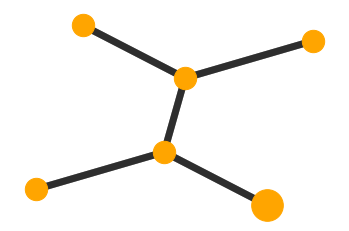

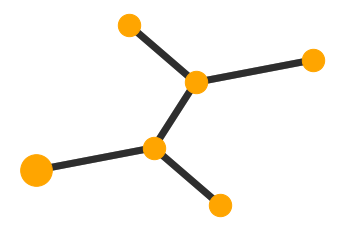

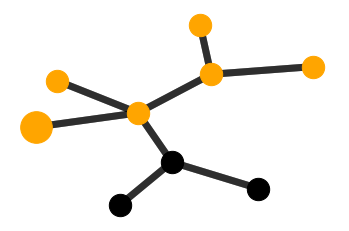

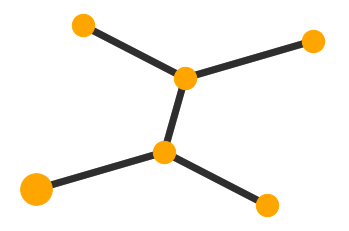

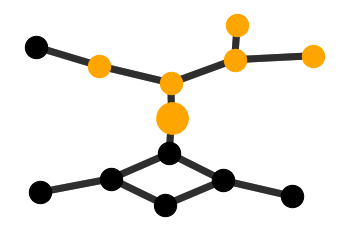

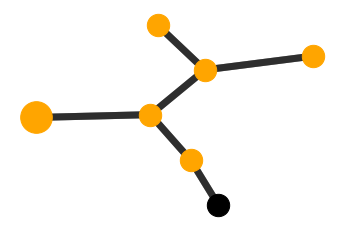

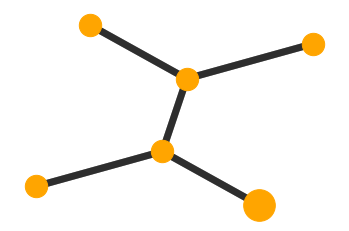

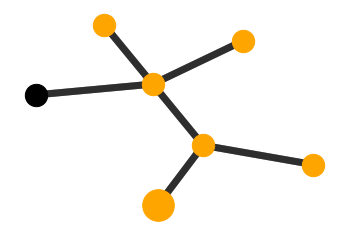

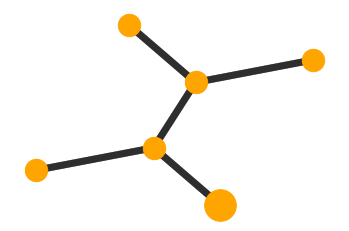

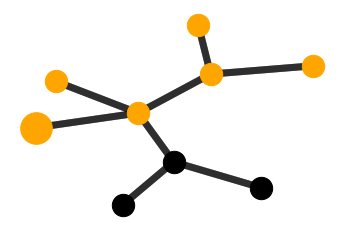

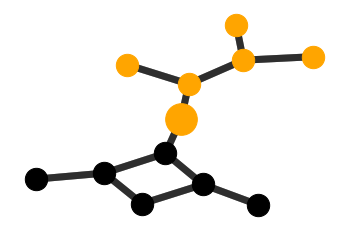

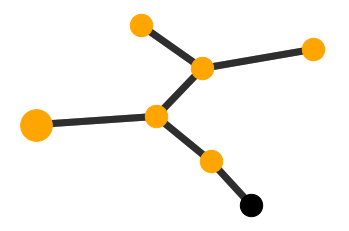

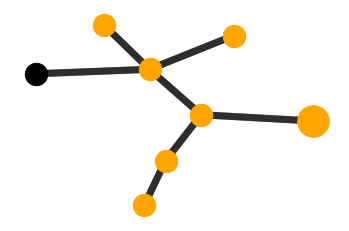

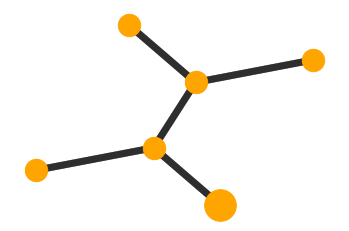

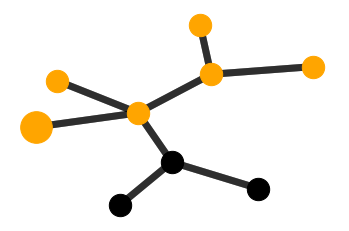

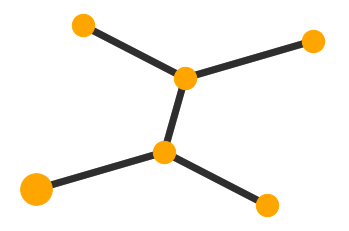

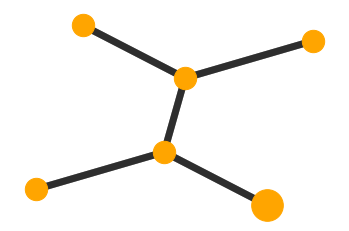

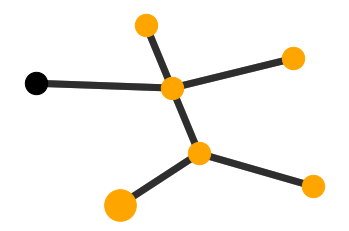

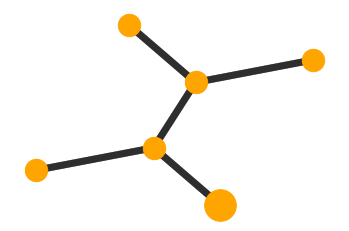

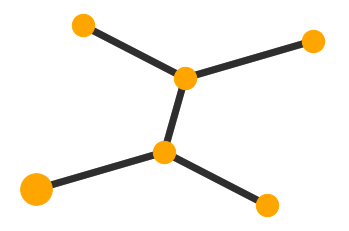

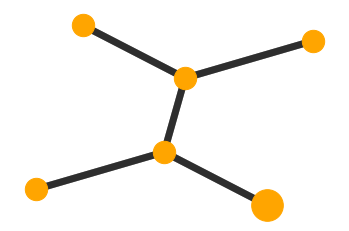

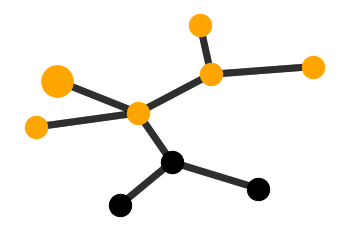

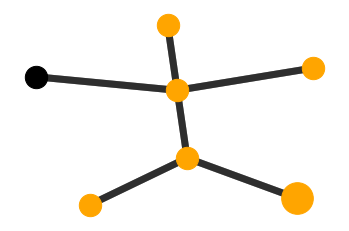

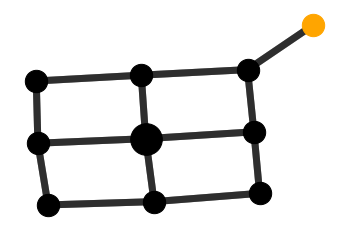

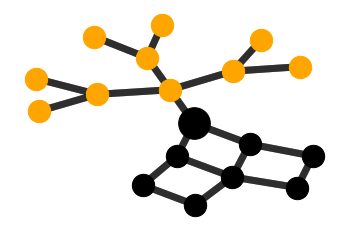

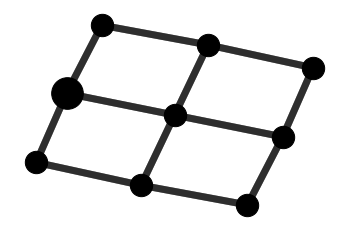

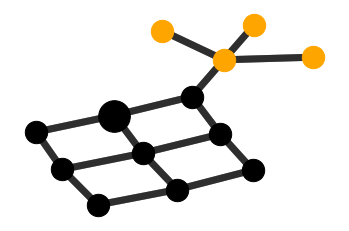

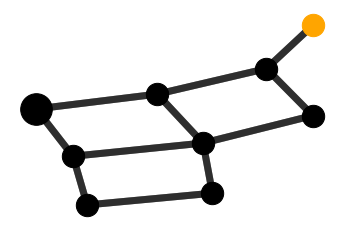

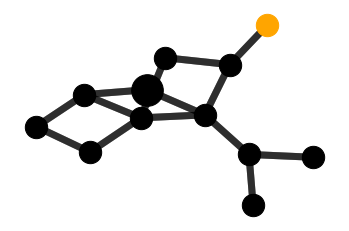

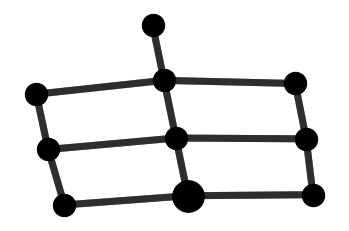

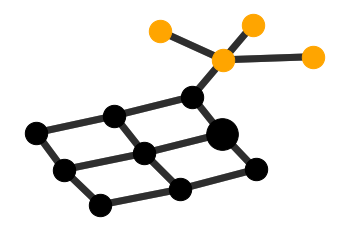

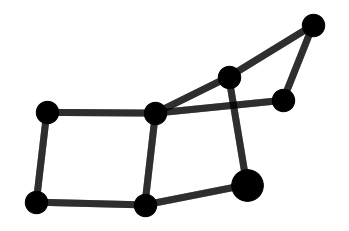

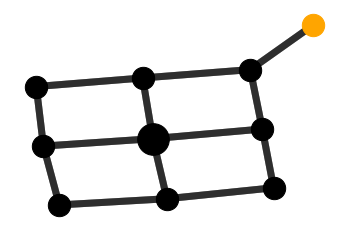

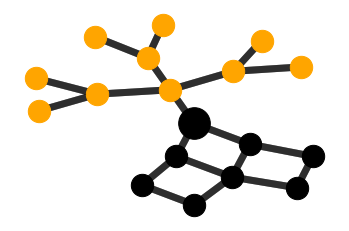

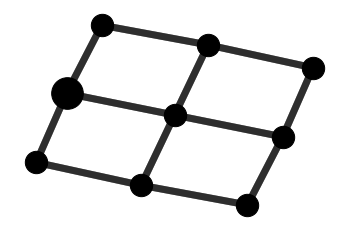

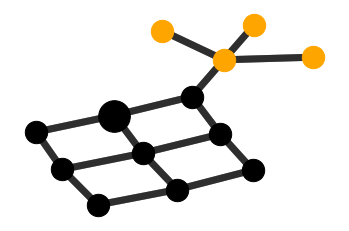

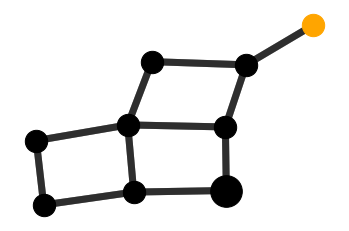

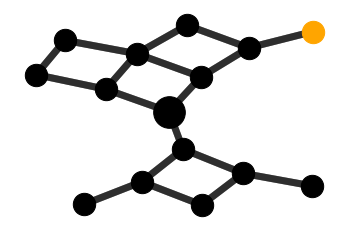

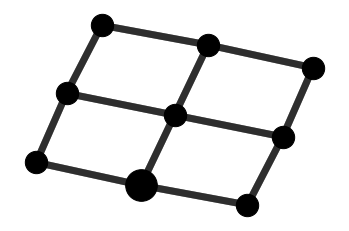

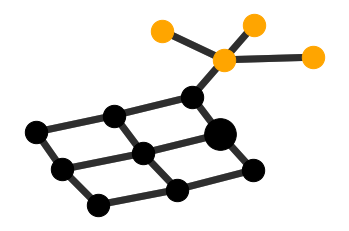

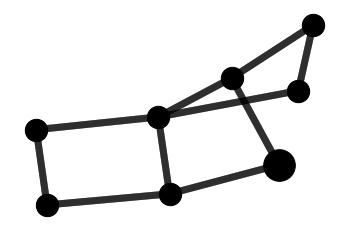

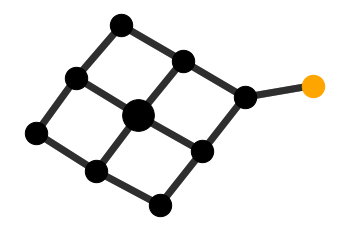

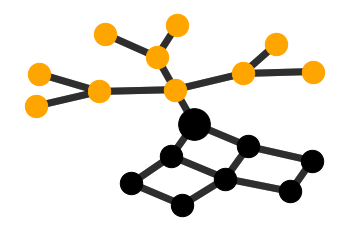

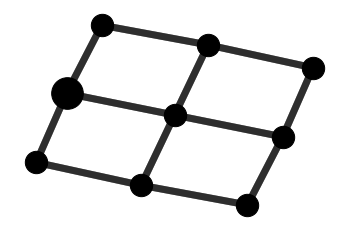

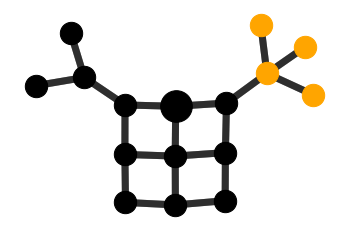

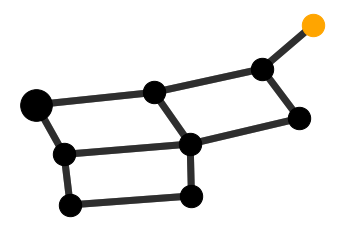

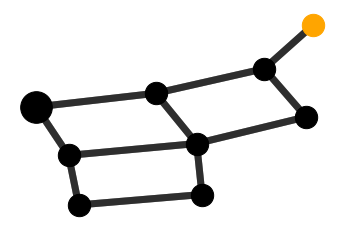

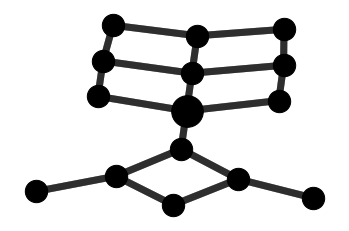

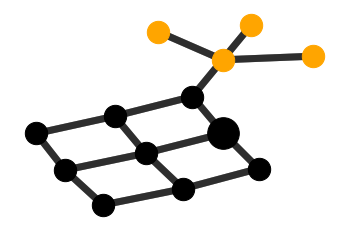

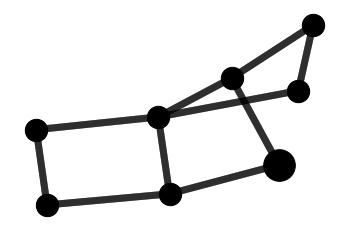

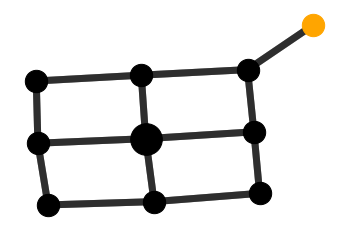

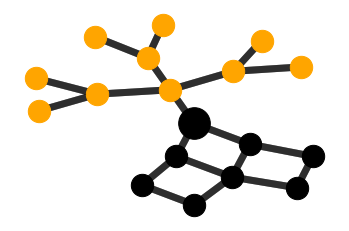

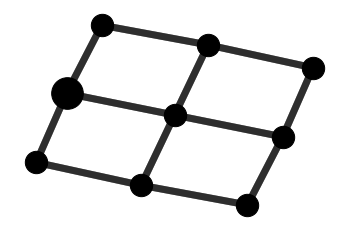

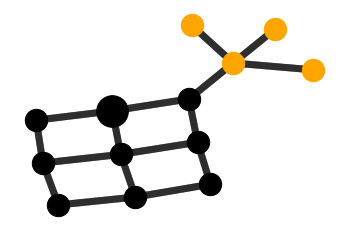

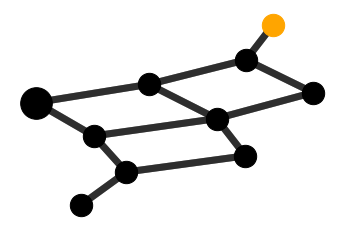

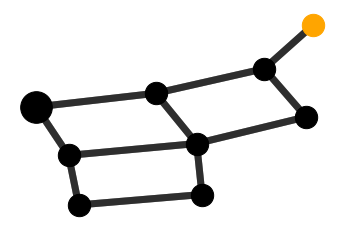

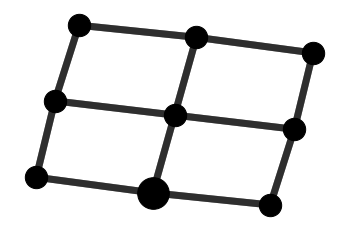

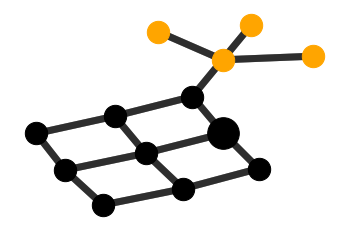

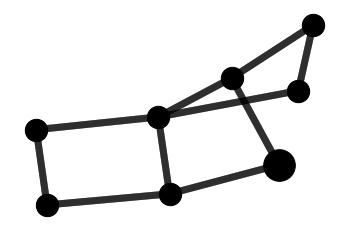

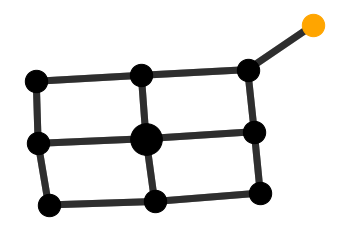

In [ ]:
# select some nodes (by index) for qualitative explain
# let's use the same indices as used in the original paper
# should ideally iterate only over test or validation nodes?
indices = range(400, 700, 5)
explainer.prepare(indices)

for idx in indices:
  graph, expl = explainer.explain(idx)
  plot(graph, expl, labels, idx, 12, 100, dataset_name_re, show=True)

In [ ]:
# more objective evaluation
explanation_labels, indices = load_dataset_ground_truth(dataset_name_re)

auc_evaluation = AUCEvaluation(task, explanation_labels, indices)
inference_eval = EfficiencyEvluation()

auc, time = run_experiment(inference_eval, auc_evaluation, explainer, indices)
print(auc)
print(time)

100%|██████████| 289/289 [00:56<00:00,  5.12it/s]


0.5064371923644797
195.4751097207251


In [ ]:
## TODO: Implementation not vetted properly
# model predictive accuracy for reference
clf_forward = model.forward(features, graphs)
clf_logits = torch.nn.Softmax(dim=1)(clf_forward)
clf_preds = clf_logits.argmax(dim=1)

clf_acc = (labels == clf_preds).float().mean()
print(f"Accuracy: {clf_acc}")

# to verify that model (predictions) are reasonable
# predicting all 0s in case PGExplainer so may not have a great model (or a bug in model files transfer/loading)
print(np.unique(labels, return_counts=True))
print(np.unique(clf_preds, return_counts=True))

Accuracy: 0.41510966420173645
(array([0, 1]), array([511, 720]))
(array([0]), array([1231]))


In [ ]:
# some inconsistency between what I get and what is being reported
print(f"This model obtained: Train Acc: {checkpoint['train_acc']:.4f}, Val Acc: {checkpoint['val_acc']:.4f}, Test Acc: {checkpoint['test_acc']:.4f}.")

This model obtained: Train Acc: 0.9634, Val Acc: 0.9919, Test Acc: 0.9919.


## Data Loading (from GSAT; redundant now)

In [ ]:
from torch_geometric.data import Batch
from torch_geometric.utils import degree
from torch_geometric.loader import DataLoader

from ogb.graphproppred import PygGraphPropPredDataset
from data_loader import SynGraphDataset  # enough for nc (node classification) tasks; other funcs important for graph classification


def get_random_split_idx(dataset, splits, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    print('[INFO] Randomly split dataset!')
    idx = np.arange(len(dataset))
    np.random.shuffle(idx)

    n_train, n_valid = int(splits['train'] * len(idx)), int(splits['valid'] * len(idx))
    train_idx = idx[:n_train]
    valid_idx = idx[n_train:n_train+n_valid]
    test_idx = idx[n_train+n_valid:]

    return {'train': train_idx, 'valid': valid_idx, 'test': test_idx}


def get_loaders_and_test_set(batch_size, dataset=None, split_idx=None, dataset_splits=None):
    if split_idx is not None:
        assert dataset is not None
        train_loader = DataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(dataset[split_idx["test"]], batch_size=batch_size, shuffle=False)
        test_set = dataset.copy(split_idx["test"])  # For visualization
    else:
        assert dataset_splits is not None
        train_loader = DataLoader(dataset_splits['train'], batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(dataset_splits['valid'], batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(dataset_splits['test'], batch_size=batch_size, shuffle=False)
        test_set = dataset_splits['test']  # For visualization
    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}, test_set


def get_data_loaders(data_dir, dataset_name, batch_size, splits, random_state):
    multi_label = False
    assert dataset_name in ['ba_shapes', 'ba_community', 'tree_grid', 'tree_cycle']

    dataset = SynGraphDataset(data_dir, dataset_name)
    split_idx = get_random_split_idx(dataset, splits)
    loaders, test_set = get_loaders_and_test_set(batch_size, dataset=dataset, split_idx=split_idx)
    train_set = dataset[split_idx["train"]]

    x_dim = test_set[0].x.shape[1]
    edge_attr_dim = 0 if test_set[0].edge_attr is None else test_set[0].edge_attr.shape[1]
    if isinstance(test_set, list):
        num_class = Batch.from_data_list(test_set).y.unique().shape[0]
    elif test_set.data.y.shape[-1] == 1 or len(test_set.data.y.shape) == 1:
        num_class = test_set.data.y.unique().shape[0]
    else:
        num_class = test_set.data.y.shape[-1]
        multi_label = True

    print('[INFO] Calculating degree...')
    batched_train_set = Batch.from_data_list(train_set)
    d = degree(batched_train_set.edge_index[1], num_nodes=batched_train_set.num_nodes, dtype=torch.long)
    deg = torch.bincount(d, minlength=10)

    aux_info = {'deg': deg, 'multi_label': multi_label}
    return loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info

In [ ]:
dataset_name = 'tree_grid'
data_dir = f"{BASE_DIR}/data"
dataset = SynGraphDataset(data_dir, dataset_name)

In [ ]:
# can see various dataset details through available class attributes
# some samples below
print(len(dataset))  # should be 1 for node classification
print(dataset.num_node_features)
print(f"Num Train: {dataset.data.train_mask.sum()}")
print(dataset.data)

1
10
Num Train: 984
Data(x=[1231, 10], edge_index=[2, 3130], y=[1231], train_mask=[1231], val_mask=[1231], test_mask=[1231])


In [ ]:
init_metric_dict = {'metric/best_clf_epoch': 0, 'metric/best_clf_valid_loss': 0,
                    'metric/best_clf_train': 0, 'metric/best_clf_valid': 0, 'metric/best_clf_test': 0,
                    'metric/best_x_roc_train': 0, 'metric/best_x_roc_valid': 0, 'metric/best_x_roc_test': 0,
                    'metric/best_x_precision_train': 0, 'metric/best_x_precision_valid': 0, 'metric/best_x_precision_test': 0}

In [ ]:
dataset_name = 'ba_2motifs'
model_name = 'GIN'
method_name = 'GSAT'
cuda_id = 0  # set to -1 to use cpus
seed = 0
# set_seed(seed)

In [ ]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)

In [ ]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1})
model_config['deg'] = aux_info['deg']

[INFO] Randomly split dataset!
[INFO] Calculating degree...
